In [1]:
from instance import *
from evaluator import *

import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple

# 03/out

In [2]:
def display_grid_and_path(inst, evaluator, path):
    """
    Display a grid with nodes and path coverage visualization.
    
    Args:
        inst: AgcspInstance object containing grid_nodes and obstacle_nodes
        evaluator: AgcspEvaluator object to calculate coverage
        path: List of (row, col) tuples representing the path
    """
    covered_nodes = evaluator.get_covered_nodes_list(path)
    
    total_nodes = len(inst.grid_nodes)
    covered_count = len(covered_nodes)
    coverage_percentage = (covered_count / total_nodes) * 100 if total_nodes > 0 else 0
    
    # Check for obstacle coverage
    covered_obstacles = []
    obstacle_warning = ""
    if hasattr(inst, 'obstacle_nodes') and len(inst.obstacle_nodes) > 0:
        covered_set = set(map(tuple, covered_nodes))
        covered_obstacles = [obs for obs in inst.obstacle_nodes if tuple(obs) in covered_set]
        if covered_obstacles:
            obstacle_warning = f"{len(covered_obstacles)} obstacles covered!"
    
    plt.figure(figsize=(12, 10))
    
    # Plot valid nodes
    plt.scatter(inst.grid_nodes[:, 0], inst.grid_nodes[:, 1], c='#AAAAAA', s=3, 
               label='Uncovered Nodes', alpha=0.7)
    
    if len(covered_nodes) > 0:
        plt.scatter(covered_nodes[:, 0], covered_nodes[:, 1], c='#00AA44', s=4, 
                   label='Covered Nodes', alpha=0.8)
    
    # Plot obstacles
    if hasattr(inst, 'obstacle_nodes') and len(inst.obstacle_nodes) > 0:
        plt.scatter(inst.obstacle_nodes[:, 0], inst.obstacle_nodes[:, 1], c='#CC0000', s=4, 
                   marker='s', label='Obstacles', linewidths=0.5)
        
        # Highlight covered obstacles
        if covered_obstacles:
            covered_obstacles_arr = np.array(covered_obstacles)
            plt.scatter(covered_obstacles_arr[:, 1], covered_obstacles_arr[:, 0], 
                       c='#FF6600', s=10, marker='D', 
                       linewidths=2, label='Covered Obstacles')
    
    # Plot path
    path_arr = np.array(path)
    plt.plot(path_arr[:, 0], path_arr[:, 1], color='#9900CC', linewidth=3, 
             label='Sprayer Path', marker='o', markersize=6, markerfacecolor='white', 
             markeredgecolor='#9900CC', markeredgewidth=2)
    
    plt.axis('equal')
    plt.legend(loc='upper right', framealpha=0.9)
    
    title = f'Coverage: {covered_count}/{total_nodes} nodes ({coverage_percentage:.1f}%){obstacle_warning}'
    plt.title(title, fontsize=12, fontweight='bold')
    
    print(f"Coverage: {covered_count}/{total_nodes} nodes ({coverage_percentage:.1f}%)")
    if hasattr(inst, 'obstacle_nodes') and len(inst.obstacle_nodes) > 0:
        print(f"Obstacles: {len(covered_obstacles)}/{len(inst.obstacle_nodes)} covered")
        if covered_obstacles:
            print("WARNING: Sprayer is covering obstacles!")
    
    plt.show()

In [3]:
# Create a circular grid with inner obstacles
center_r, center_c = 100, 100
outer_radius = 80
inner_radius = 30
r_grid, c_grid = np.mgrid[0:200, 0:200]
dist_from_center = np.sqrt((r_grid - center_r)**2 + (c_grid - center_c)**2)
grid_nodes = np.argwhere(dist_from_center <= outer_radius)
obstacle_nodes = np.argwhere(dist_from_center <= inner_radius)

circular_inst = AgcspInstance(grid_nodes, obstacle_nodes, 15)
circular_evaluator = AgcspEvaluator(circular_inst)

Coverage: 5357/20081 nodes (26.7%)
Obstacles: 1122/2821 covered


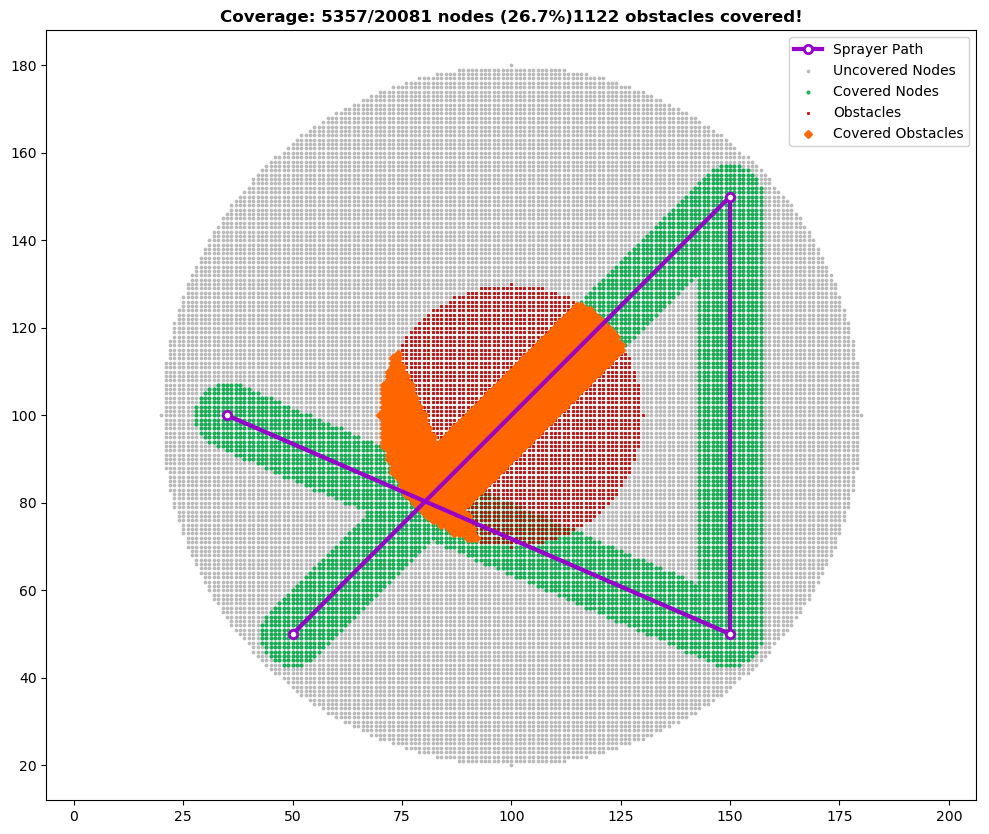

In [27]:
path=[(50, 50), (150, 150), (150, 50), (35, 100)]
display_grid_and_path(circular_inst, circular_evaluator, path)

In [5]:
sol = AgcspSolution(path)
display(circular_evaluator.coverage_proportion(sol))
display(sol.cache['hits_obstacle'])
circular_evaluator.manouver_complexity_penalty(sol)

0.1847019570738509

True

1.7071067811865475

In [6]:
circular_evaluator.objfun(sol)

243.9437610614222

# Testing neighborhood step evaluations

### a) Node Removal Step

In [7]:
circular_evaluator.evaluate_removal_delta(sol, 1)

-143.9437610614222

In [8]:
sol.path = np.delete(sol.path, 1, axis=0)

In [9]:
circular_evaluator.objfun(sol)

100.91648822269808

### c) Node swap step

In [28]:
sol = AgcspSolution(path)
circular_evaluator.objfun(sol)

370.6597815865669

In [29]:
circular_evaluator.evaluate_swap_delta(sol, 2, 1)

new_path: [[ 50  50]
 [150  50]
 [150 150]
 [ 35 100]]
new_objfun: 328.5461584664823


-42.11362312008458

In [30]:
sol.path

array([[ 50,  50],
       [150, 150],
       [150,  50],
       [ 35, 100]])

In [31]:
# Perform node swap
temp = sol.path[2].copy()
sol.path[2] = sol.path[1]
sol.path[1] = temp

In [32]:
circular_evaluator.objfun(sol)

328.5461584664823